# Transient Heat Transfer Tutorial Using DifferentialEquations.jl
# Extended with Non-Linear Dirichtlet Boundary Conditions 

In [1]:
using Ferrite
using SparseArrays
using LinearAlgebra         # provides mul! 
using UnPack                # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq        # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl
using WriteVTK
using Plots                 # provides contour plot of cell averages 

## Section 1: Introduction
We extend the heat transfer tutorial of Ferrite with time integration using DifferentialEquations.jl. We also implement non-linear Dirichlet boundary conditions. 
1. Case (1/2): Linear Boundary Conditions (Ferrite Heat Transfer Tutorial. Reset volumetric source to zero. Ramped linear boundary source only. Zero initial guess);
2. Case (2/2): Non-Linear Dirichlet Boundary Conditions (No volumetric source. Ramped <b>non-linear</b> boundary source only. Zero initial guess);
   
(requires further elaboration).

## Section 2: Auxiliary Data Structures and Functions 

In [53]:
struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    dh::DofHandler
    cvu::CellValues
    fvu::FacetValues
    u::Vector
end

function mypostprocess(u, dh, cvu, nels)
 
    area = [] 
    myu  = [] 

    for (cell_num, cell) in enumerate(CellIterator(dh))

        dof_range_u = dof_range(dh,:u)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        Ferrite.reinit!(cvu, cell)

        cellarea = 0. 
        cellu = 0 

        # compute cell average of u 
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            cellu_qp = function_value(cvu, q_point, uloc)
            cellarea += dΩ 
            cellu += cellu_qp*dΩ
        end

        append!(area, cellarea)
        append!(myu, cellu)
    
    end  

    myu2d = reshape(myu, nels)
    
    return area, myu2d  
end 

mypostprocess (generic function with 1 method)

## Section 3: Case (1/2): Mesh Generation, Spatial Discretization and Time Constants 

In [66]:
nels = (5,5)
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh);
M = allocate_matrix(dh);
f = zeros(ndofs(dh));

max_temp = 100
Δt = 1
T = 200
t_rise = 100
ch = ConstraintHandler(dh);

∂Ω₁ = union(getfacetset.((grid,), ["left", "right"])...)
dbc = Dirichlet(:u, ∂Ω₁, (x, t) -> 0)
add!(ch, dbc);

∂Ω₂ = union(getfacetset.((grid,), ["top", "bottom"])...)
dbc = Dirichlet(:u, ∂Ω₂, (x, t) -> max_temp * clamp(t / t_rise, 0, 1))
add!(ch, dbc)
close!(ch)
update!(ch, 0.0);

In [ ]:
# here is how to verify how the update of the constraint handler works: intended for later use 
update!(ch,1.)
ch.prescribed_dofs
ch.dofcoefficients
ch.inhomogeneities

In [67]:
function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

        n_basefuncs = getnbasefunctions(cellvalues)
        Ke = zeros(n_basefuncs, n_basefuncs)
        fe = zeros(n_basefuncs)

        assembler = start_assemble(K, f)

        for cell in CellIterator(dh)

            fill!(Ke, 0)
            fill!(fe, 0)

            Ferrite.reinit!(cellvalues, cell)

            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    ∇v = shape_gradient(cellvalues, q_point, i)
                    fe[i] += 0. * v * dΩ
                    for j in 1:n_basefuncs
                        ∇u = shape_gradient(cellvalues, q_point, j)
                        Ke[i, j] += 1.0e-3 * (∇v ⋅ ∇u) * dΩ
                    end
                end
            end

            assemble!(assembler, celldofs(cell), Ke, fe)
        end
        return K, f
end

function assemble_M!(M::SparseMatrixCSC, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
        Me = zeros(n_basefuncs, n_basefuncs)
        assembler = start_assemble(M)

        for cell in CellIterator(dh)
            fill!(Me, 0)
            Ferrite.reinit!(cellvalues, cell)
            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    for j in 1:n_basefuncs
                        u = shape_value(cellvalues, q_point, j)
                        Me[i, j] += (v * u) * dΩ
                    end
                end
            end

        assemble!(assembler, celldofs(cell), Me)
        end
            
        return M
end

assemble_M! (generic function with 1 method)

In [94]:
#@code_warntype assemble_K!(K, f, cvu, dh)

In [68]:
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
A = (Δt .* K) + M;

rhsdata = get_rhs_data(ch, A);

## Section 4: Case (1/2): Time-Integration Using DifferentialEquations.jl

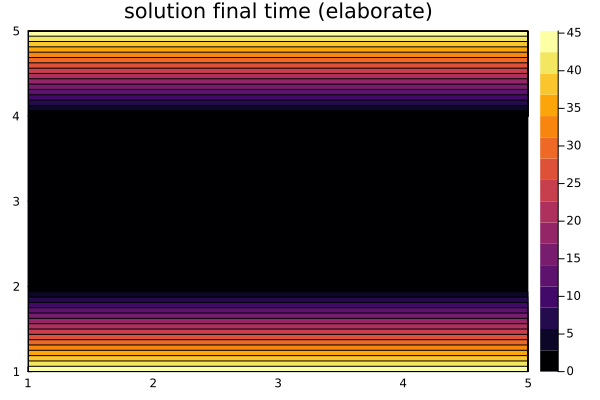

In [57]:
# doubt? one is **not** allowed to mutate the input argument u_uc to apply the boundary conditions \n",
function heat_rhs!(du, u_uc, p::RHSparams, t)

    # display(t)

    @unpack K, ch, dh, cvu, fvu, u = p    

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (diffusion operator)
    mul!(du, K, u) # du .= K * u

    return
end

function heat_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cvu, fvu, u = p

    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)  

    return apply!(J, ch)    
end

# set time constants 
T   = 200.0
Δt₀ = 1. 

# allocate, assemble and apply bc to mass matrix 
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess
uinit = zeros(ndofs(dh))

# set parameters 
p = RHSparams(K, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-3, abstol = 1e-3); 

# post-processing 
area, myu2d = mypostprocess(sol.u[end], dh, cvu, nels) 
contour(myu2d', fill=true, title="solution final time (elaborate)")

## Section 5: Case (2/2): Mesh Generation, Spatial Discretization and Time Constants 
Note that in Case (2/2) the left boundary is not included in the constraint handler. 

In [60]:
nels = (10,10)
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh);
M = allocate_matrix(dh);

f = zeros(ndofs(dh));

ch = ConstraintHandler(dh);

left_patch = getfacetset(dh.grid, "left")
∂Ω₂ = union(getfacetset.((grid,), ["top", "bottom", "right"])...)
dbc2 = Dirichlet(:u, ∂Ω₂, (x, t) -> 0)
add!(ch, dbc2)
close!(ch);

## Section 6: Case (2/2): Time-Integration Using DifferentialEquations.jl

In [61]:
t_rise = 1
res_functional(u,t) = u^2 - 2*(t*(t<=t_rise)+(t>t_rise))
dures_functional(u) = 2*u

function heat_rhs_element!(due, ue, fvu,t)
    n_basefuncs = getnbasefunctions(fvu)
    for qp in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, qp)
        # evaluate function in quad point 
        u_qp = function_value(fvu, qp, ue)
        val_qp = res_functional(u_qp,t)
        for j in 1:n_basefuncs
            φⱼ = shape_value(fvu, qp, j)
            due[j] += val_qp*φⱼ*dΓ
        end
    end   
    # display(due)
    return 
end 
    
function heat_jac_element!(Je, ue, fvu)
    n_basefuncs = getnbasefunctions(fvu)
    for qp in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, qp)
        # evaluate function in quad point 
        u_qp = function_value(fvu, qp, ue)
        duval_qp = dures_functional(u_qp)
        for j in 1:n_basefuncs
            φⱼ = shape_value(fvu, qp, j)
            for i in 1:n_basefuncs
                φᵢ = shape_value(fvu, qp, i)
                Je[j, i] += duval_qp*φᵢ*φⱼ* dΓ
            end
        end
    end   
    return 
end 

heat_jac_element! (generic function with 1 method)

In [62]:
function heat_rhs!(du, u_uc, p::RHSparams, t)

    # display(t)

    @unpack K, ch, dh, cvu, fvu, u = p    

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution 
    mul!(du, K, u) # du .= K * u

    # Non-Linear contribution 
    range_u = dof_range(dh, :u) 
    n_basefuncs = getnbasefunctions(cvu)
    ue  = zeros(n_basefuncs)
    due = zeros(n_basefuncs)

    for facet in FacetIterator(dh, left_patch)
        Ferrite.reinit!(fvu, facet)
        u_celldofs = @view celldofs(facet)[range_u]
        ue .= @views u[u_celldofs] # u is fetched outside of for-loop 
        fill!(due, 0)
        heat_rhs_element!(due, ue, fvu, t) # first argument is the input output argument 
        assemble!(du, u_celldofs, due) # add to previous values  
    end 
    
    return
end
    
function heat_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cvu, fvu, u = p    

    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)  

    assembler = start_assemble(J; fillzero = false)

    n_basefuncs = getnbasefunctions(cvu)
    ue  = zeros(n_basefuncs)
    Je  = zeros(n_basefuncs, n_basefuncs)
    due = zeros(n_basefuncs)
    range_u = dof_range(dh, :u) 

    for facet in FacetIterator(dh, left_patch)
        Ferrite.reinit!(fvu, facet)
        u_celldofs = @view celldofs(facet)[range_u]
        ue .= @views u[u_celldofs] # u is fetched outside of for-loop 
        fill!(Je, 0)
        heat_jac_element!(Je, ue, fvu) # first argument is the input output argument 
        assemble!(assembler, u_celldofs, Je) # add to previous values 
    end    

    return apply!(J, ch)    
end

heat_jac! (generic function with 1 method)

In [63]:
# test the RHS function 
du   = zeros(ndofs(dh));
u_uc = ones(ndofs(dh));
p    = RHSparams(K, ch, dh, cvu, fvu, copy(u_uc));

heat_rhs!(du, u_uc, p::RHSparams, 0.)
du;

In [64]:
# test the Jacobian function
du   = zeros(ndofs(dh));
u_uc = ones(ndofs(dh));
p    = RHSparams(K, ch, dh, cvu, fvu, copy(u_uc));

J = allocate_matrix(dh,ch);
heat_jac!(J, u_uc, p::RHSparams, 0.)
J 

121×121 SparseMatrixCSC{Float64, Int64} with 961 stored entries:
⎡⢿⢗⣀⠀⠀⠀⠀⡶⡂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠘⢿⣷⣀⠀⠀⠀⢶⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠘⢿⣷⣀⠀⠀⢶⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢠⡤⠀⠀⠀⠘⠿⣧⠄⠀⠶⡤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠈⠈⠘⠷⢠⣄⠀⠁⠻⣦⡀⠉⠷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠉⠘⡧⡄⠈⠛⣤⡀⠉⢣⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠙⢧⡄⠈⠻⣦⡀⠉⠷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢶⡄⠈⠱⣦⡀⠉⠷⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢧⡄⠈⠻⣦⡀⠙⢷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⢧⣄⠈⠟⣥⡀⠹⢫⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢷⣄⡈⠻⣦⣀⠘⢳⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠋⢶⣀⠘⠱⣦⡀⠘⢲⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢶⣀⠈⠻⢆⡀⠘⠳⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠘⢶⣀⠈⠻⣦⡀⠙⢳⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢢⣄⠈⠛⣤⡀⠘⢳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢶⣀⠈⠻⣦⡀⠙⢷⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢶⣄⠈⠻⣦⡀⠙⠷⣆⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢷⣄⠈⠻⣦⡀⠉⠷⣄⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⢧⡄⠈⠟⣥⡀⠉⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢧⡄⠈⠻⣦⎦

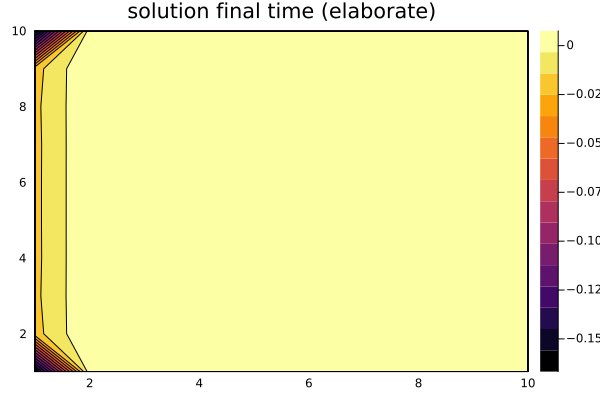

In [65]:
# set time constants 
T   = 2. 

# allocate, assemble and apply bc to mass matrix 
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess 
uinit = zeros(ndofs(dh))

# set parameters 
p = RHSparams(K, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-3, abstol = 1e-3)

# post-processing 
area, myu2d = mypostprocess(sol.u[end], dh, cvu, nels) 
contour(myu2d', fill=true, title="solution final time (elaborate)")

In [ ]:
?finish_assemble